In [5]:
# def note_similarity_matrix(window, rate, sigma=1/36, num_harmonics = 1):
#     # TODO: make this cleaner
#     len_fft = window//2 + 1
# #     logs = (math.log(27.5,2) + np.arange(0,10,(1/12))) # A0 through Ab9
#     logs = (math.log(55,2) + np.arange(0,8,(1/12))) #A1 through Ab8
    
#     freqs = np.log2(np.arange(1, len_fft) * (rate/window))
#     mat = np.zeros((len_fft, len(logs)))
# #     sigma = 1/24
    
#     for i in range(1, len_fft): #do not count frequency 0
#         for j in range(len(logs)):
#             mat[i][j] = freqs[i-1] - logs[j]
            
#     mat = 2 * (1 - normal_dist().cdf(np.abs(mat/sigma)))

# #     for i in range(1, len_fft):
# #         s = sum(mat[i]) 
# #         if s > 0.0:
# #             mat[i] /= s
#     mat[0][:] = 0 #clear frequency 0
    
#     return mat

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, irfft
import math
from scipy.stats import norm as normal_dist

# NOTES=[((' ABb B CDb DEb E FGb GAb'[2*i%24:2*i%24+2]+str(i//12)).strip(),27.5*2**(i/12)) for i in range(120)]

import time

In [7]:
def parse_wav(b):
    assert b[0:4] == b'RIFF', "Chunk ID did not match 'RIFF'"
    chunk_size = int.from_bytes(b[4:8], byteorder="little")
    assert b[8:12] == b'WAVE', "Format did not match 'WAVE'"
    assert b[12:16] == b'fmt ', "Format subchunk ID did not match 'fmt '"
    chunk1_size = int.from_bytes(b[16:20], byteorder="little")
    audio_format = int.from_bytes(b[20:22], byteorder="little")
    assert audio_format == 1, "Audio Format is not PCM (i.e. data is compressed)"
    channels = int.from_bytes(b[22:24], byteorder="little")
    sample_rate = int.from_bytes(b[24:28], byteorder="little")
    byte_rate = int.from_bytes(b[28:32], byteorder="little")
    block_align = int.from_bytes(b[32:34], byteorder="little")
    bits_per_sample = int.from_bytes(b[34:36], "little")
    assert (bits_per_sample % 8) == 0 , "bits per sample is not a multiple of 8"
    assert (sample_rate * (bits_per_sample/8) * channels == byte_rate), "byte_rate != bytes_per_sample * sample_rate * num_channels"
    # from 36 onwards, we might have additional metadata
    data_idx = 36
    while True:
        temp_chunk_id = b[data_idx: data_idx + 4]
        temp_chunk_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
        if temp_chunk_id != b'data':
            data_idx += temp_chunk_size + 8 # add 8 to include the chunk_id and chunk_size fields
        else:
            break
            
    assert b[data_idx: data_idx + 4] == b'data', "Format subchunk ID did not match 'data'"
    sample_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
    sample_begin = data_idx + 8
    assert sample_size % block_align == 0, "size of sample in bytes is not divisible by number of bytes per sample"
    
    return {
        "File Size": chunk_size + 8,
        "Audio Format": "PCM",
        "Channels": channels,
        "Sample Rate": sample_rate,
        "Byte Rate": byte_rate,
        "Block Align (bytes per sample)": block_align,
        "Bits Per Sample Per Channel": bits_per_sample,
        "Samples Size": sample_size,
        "Num Samples": int(sample_size/block_align),
        "File Length (seconds)": round(sample_size/(byte_rate), 3),
        "Sample Begin": sample_begin,
    }

In [85]:
def harmonic_similarity_matrix(window, rate, sigma = 1/36, num_harmonics = 1):
    len_fft = window//2 + 1
    notes = [27.5 * 2**(i/12) for i in range(120)]
    
    mat = np.zeros((len_fft, len(notes)))
    # each value in mat is the probability that a fft frequency belongs to a note or it's harmonic series
    temp = np.zeros((len_fft, len(notes)))
    
#     log_freq = (math.log(55,2) + np.arange(0,8,(1/12)))
#     log_fft = np.log2(np)
    
    for h in range(1,1 + num_harmonics):
        for i in range(1, len_fft):
#             print(i, end="\r")
            fft_n = i * (rate/window)
            for j in range(len(notes)):
                note = notes[j]
                factor = h
                freq = factor * note
                v = abs(math.log(freq,2) - math.log(fft_n,2))
                temp[i][j] = (v/sigma)
        mat += 2 * (1- normal_dist().cdf(temp))
    mat[0][:] = 0.0
#     for i in range(len_fft):
#         s = sum(abs(mat[i])) 
#         if s > 0.0:
#             mat[i] /= s
            
    return mat
                # 

time taken:  0.07382345199584961


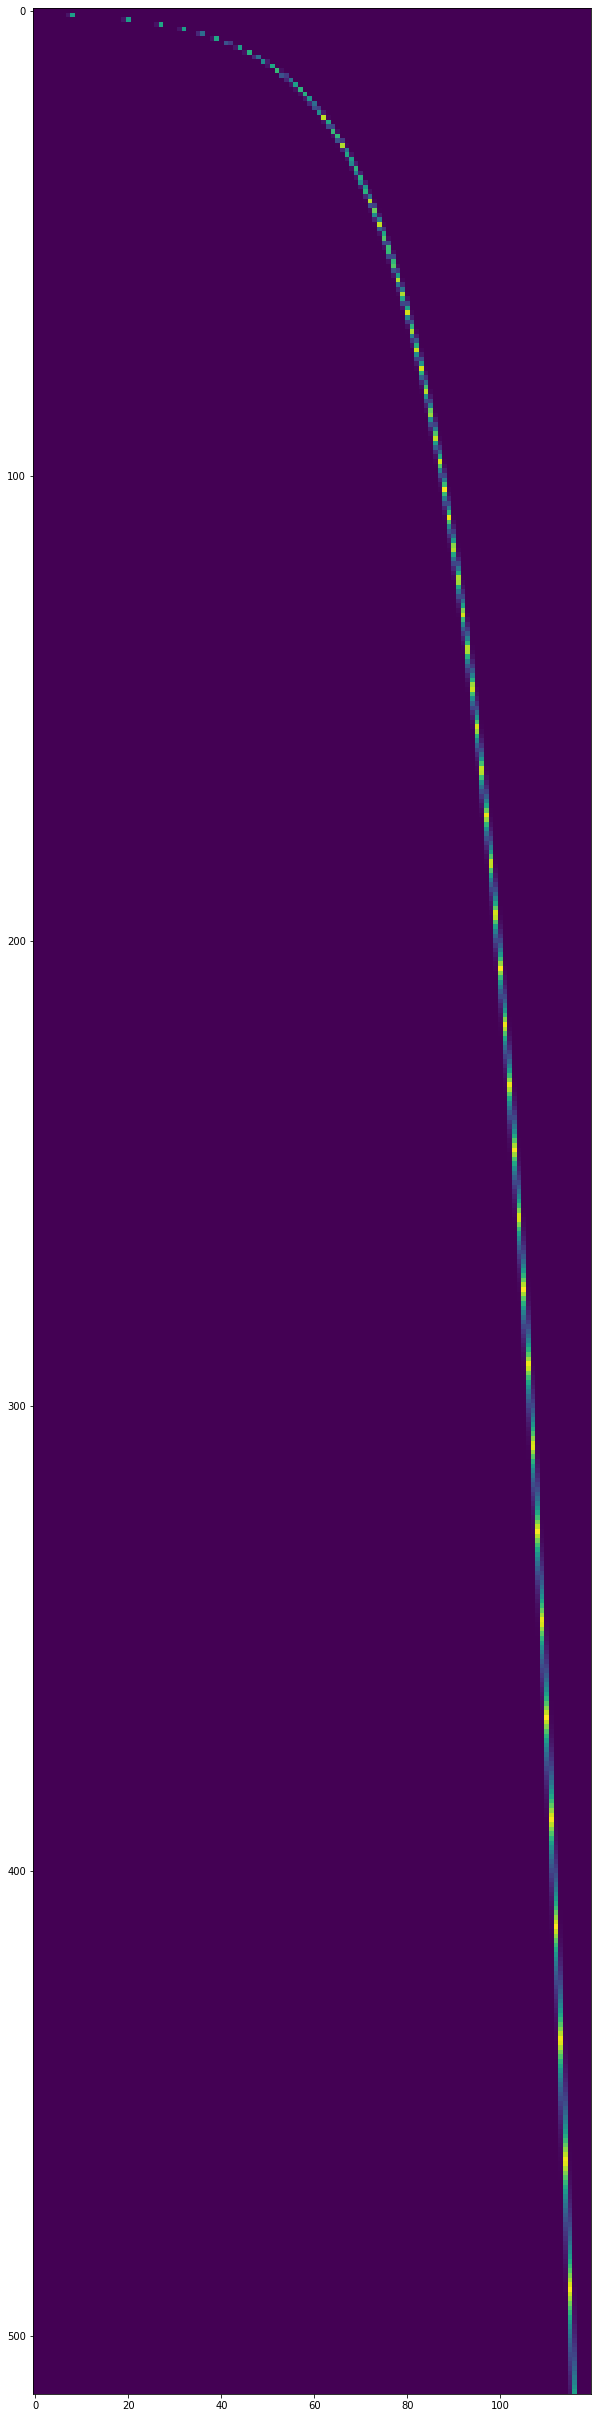

In [112]:
fig, ax = plt.subplots(figsize=(10,450))
s = time.time()
newmat = harmonic_similarity_matrix(1024, 44100, num_harmonics=1, sigma=1/30)
e = time.time()
im = ax.imshow(newmat)
print("time taken: ", e-s)
# im = ax.imshow(note_similarity_matrix(2048+1024, 44100))

In [113]:
def save_song_heatmap(song, name):
    fig, ax = plt.subplots(figsize=(len(song)//10, 120))
    plt.box(on=None)
    plt.axis('off')
    plt.xticks(np.arange(0, len(song), 3.0))
    plt.imshow(song.T[::-1], cmap='cividis')
    fig.savefig("{}.png".format(name[5:]), bbox_inches='tight')
    return fig
    plt.close(fig)

In [114]:
def process_wav_file(wav_bytes, window=2048, m_win=1):
    # TODO: determine window size as a function of sample rate
    # TODO: deal with multiple channels, different bits per sample in wav file
    # TODO: deal with fault wav file
    
    file_info = parse_wav(wav_bytes)
    num_samples = file_info['Num Samples']
    rate = file_info['Sample Rate']
    print(rate, num_samples, file_info['Byte Rate'], file_info['Channels'])
    sample_begin = file_info['Sample Begin']
#     window = 2048
    sample_len = num_samples + (window - (num_samples%window))
    print(sample_begin, sample_len)
    num_windows = sample_len//window
    num_fft_coefs = window//2 + 1
    
    samples = np.zeros(sample_len, dtype=np.int16)
    samples[:num_samples] = np.frombuffer(wav_bytes, dtype=np.int16, count=num_samples, offset=sample_begin)
    
    mov_h = np.concatenate((samples[:m_win//2], np.convolve(samples, np.ones(m_win), 'valid')//m_win, samples[-m_win//2:]))
    mov_h = mov_h.astype(np.int16)
                     
    ffts = np.zeros((num_windows, num_fft_coefs)) 

    for winnum in range(num_windows):
#         np.copyto(ffts[winnum], np.abs(rfft(samples[window*winnum:window*(winnum + 1)])))
        np.copyto(ffts[winnum], np.abs(rfft(mov_h[window*winnum:window*(winnum + 1)])))


    temp = harmonic_similarity_matrix(window, rate)
#     temp = np.matmul(note_similarity_matrix(window, rate), m)
    ret = np.matmul(ffts, temp)
    
#     ret = np.matmul(song, m2.T)
    
#     for i, row in enumerate(song):
#         for j, val in enumerate(row):
#             if val < 0.0:
#                 song[i][j] = 0.0
    
    
#     song = np.matmul(ffts, hmat)
    # anything above 256 is pretty unnecessary
#     song /= (np.max(song)/(2**8 - 1))
#     song = song.astype(np.uint8)
    
#     return song#[::,36:84]
#     return ffts
    return ret

44100 674816 88200 1
44 675840
time: 0.13957715034484863


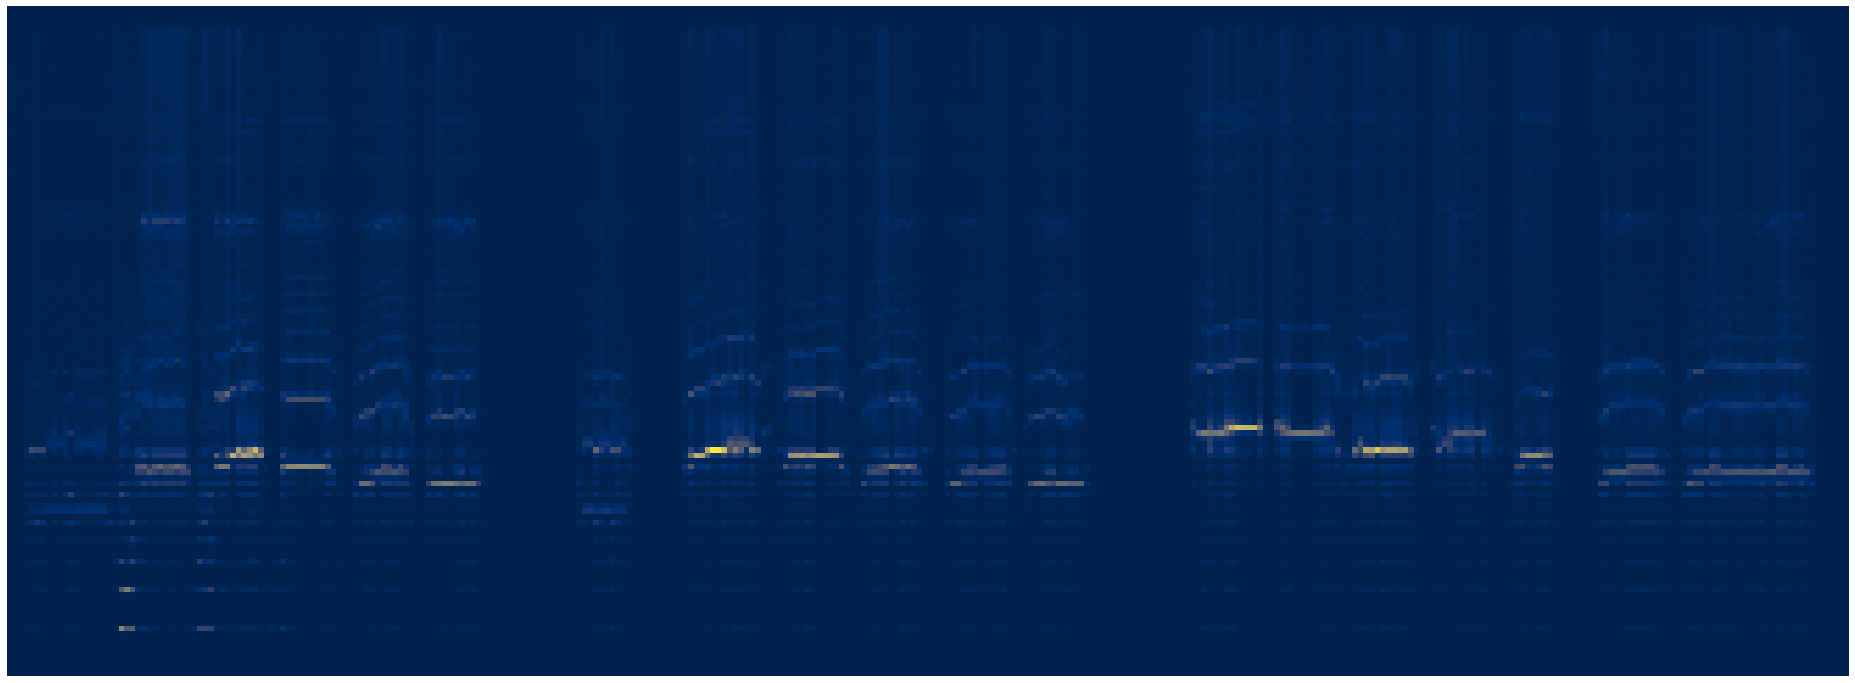

In [122]:
start = time.time()

fname = "wavs/hum3"

f = open(fname + ".wav", "rb")
bb = f.read()
f.close()

song = process_wav_file(bb, window=2048, m_win=1)

end = time.time()

print("time:", end-start)
# print("size of output in bytes: ", np.prod(song.shape))

fig = save_song_heatmap(song, fname)

44100 376832 88200 1
44 378880
time: 0.1278235912322998


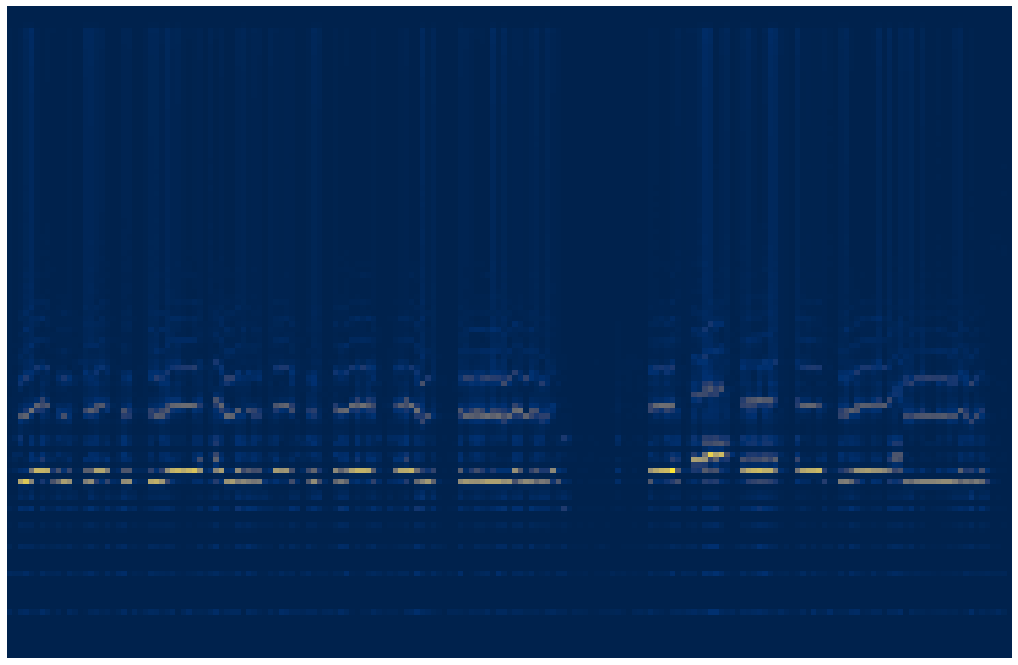

In [105]:
start = time.time()

fname = "wavs/hum2"

f = open(fname + ".wav", "rb")
bb = f.read()
f.close()

song = process_wav_file(bb, window=2048, m_win=31)

end = time.time()

print("time:", end-start)
# print("size of output in bytes: ", np.prod(song.shape))

fig = save_song_heatmap(song, fname)

In [107]:
samples[1024]

TypeError: 'NoneType' object is not subscriptable

In [46]:
8599552/1074944

8.0

In [ ]:

plt.figure(figsize=(100,10))
plt.bar(range(len(song[0])), song[1])

In [ ]:
NOTES=[(i, (' ABb B CDb DEb E FGb GAb'[2*i%24:2*i%24+2]+str(i//12)).strip(),27.5*2**(i/12)) for i in range(120)][12:108]

l = list(zip(NOTES, song[7]))
l.sort(key=lambda x: x[1], reverse=True)
l

In [ ]:
def harmonics():
    notes = [27.5 * 2**(i/12) for i in range(12, 108)]
    
    mat = np.zeros((12, len(notes)))
    sigma = 1/24
        
    for i in range(len(notes)):
        print(i, end="\r")
        note = notes[i]
        for j in range(len(notes)):
            harm = notes[j]
            
            for h in range(1,5):
                factor = 1/h
                freq = h * note
                v = abs(math.log(freq,2) - math.log(harm,2))
                mat[i%12][j] += 2 * (1- normal_dist().cdf(v/sigma))
    
    return mat

In [ ]:
m2 = harmonics()
fig, ax = plt.subplots(figsize=(1,10))
im = ax.imshow(m2.T)

In [ ]:
m = harmonics()
fig, ax = plt.subplots(figsize=(10,100))
im = ax.imshow(m.T)

In [ ]:
fig, ax = plt.subplots(figsize=(10,100))
# im = ax.imshow(np.matmul(note_similarity_matrix(2048+1024, 44100), m))
im = ax.imshow(note_similarity_matrix(2048+1024, 44100, sigma=1/48), cmap='Greys')

In [ ]:
minv = np.linalg.inv(m)

In [ ]:
fig, ax = plt.subplots(figsize=(10,100))
im = ax.imshow(np.matmul(note_similarity_matrix(2048+1024, 44100), minv))
im = ax.imshow(minv)

In [ ]:
def weighted_avg(sample):
    t = 0
    s = sum(sample)
    if s > 0.0:
        for i, x in enumerate(sample):
            t += (i*x)/s
    return round(t, 4)

In [ ]:
sample = song[0]
np.average(sample)

In [ ]:
weighted_avg(sample)

In [ ]:
song2 = [(weighted_avg(sample), sum(sample)) for sample in song]
song2

In [ ]:
sums = [sum(sample) for sample in song]
sums.sort(reverse=True)

In [ ]:
plt.hist(sums)

In [ ]:
sum(sums)

In [ ]:
cum_sums = [sums[0]]
for i in range(1, len(sums)):
    cum_sums.append(sums[i] + cum_sums[i-1])
assert cum_sums[-1] == sum(sums)
cum_sums

In [ ]:
plt.plot(cum_sums)

In [ ]:
target = cum_sums[-1] * 0.95
target_idx = -1
target

In [ ]:
for i in range(len(cum_sums)-1, 0, -1):
    if cum_sums[i] <= target:
        target_idx = i
        break

In [ ]:
target_idx

In [ ]:
len(sums)

In [ ]:
cum_sums[target_idx+1]

In [ ]:
target_sum = sums[target_idx+1]
target_sum

In [ ]:
new_song = [weighted_avg(sample) if sum(sample) > target_sum else 0 for sample in song]

In [ ]:
new_song

In [ ]:
plt.bar(range(len(new_song)), new_song)